In [17]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb

In [18]:
#data
train=pd.read_csv("dataset/train_features.csv")
y=pd.read_csv("dataset/train_labels.csv")
test=pd.read_csv("dataset/test_features.csv")
ss=pd.read_csv("dataset/submission_format.csv")

In [19]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [20]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [22]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [23]:
merged_df["year"]

0       2021
1       2021
2       2016
3       2021
4       2021
        ... 
4338    2021
4339    2016
4340    2021
4341    2021
4342    2021
Name: year, Length: 4343, dtype: int64

In [24]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [25]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

In [26]:
merged_test["year"]

0       2016
1       2016
2       2021
3       2016
4       2021
        ... 
1100    2016
1101    2021
1102    2016
1103    2021
1104    2021
Name: year, Length: 1105, dtype: int64

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

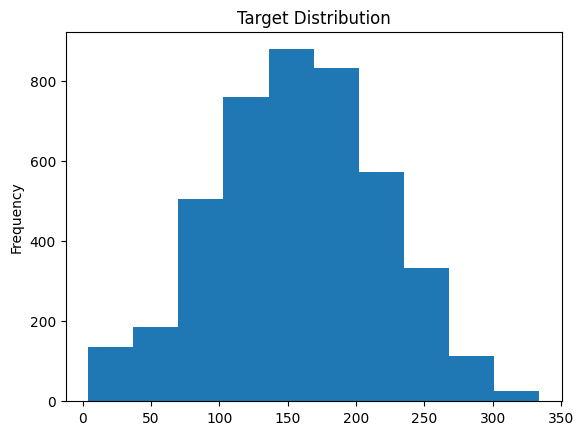

In [27]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [28]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','composite_score'],axis=1)

# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [29]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [30]:
merged_df.shape

(4343, 184)

In [31]:
train_X, val_X, train_y, val_y = train_test_split(merged_df, y,test_size=0.33,random_state=42)

In [34]:
model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42,
                          feature_fraction=0.8,
                          bagging_fraction=0.8,
                            metric='RMSE')

In [35]:
model.fit(train_X, train_y,  eval_set=(val_X, val_y))

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 2909, number of used features: 184
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is 

LGBMRegressor(bagging_fraction=0.8, feature_fraction=0.8, learning_rate=0.01,
              metric='RMSE', n_estimators=1000, random_state=42)

In [36]:
#The model shall handle missing values and encode categorical columns
model2 = CatBoostRegressor(
    iterations=7000,
    learning_rate=0.01,
    depth=10,
    loss_function='RMSE',  # Default regression loss
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)

In [37]:
model2.fit(train_X, train_y,  eval_set=(val_X, val_y))

0:	learn: 60.6268639	test: 60.7188713	best: 60.7188713 (0)	total: 77.6ms	remaining: 9m 3s
100:	learn: 45.2728009	test: 46.7287140	best: 46.7287140 (100)	total: 3.01s	remaining: 3m 25s
200:	learn: 38.9594662	test: 42.2471426	best: 42.2471426 (200)	total: 6.37s	remaining: 3m 35s
300:	learn: 35.3053344	test: 40.4738508	best: 40.4738508 (300)	total: 9.77s	remaining: 3m 37s
400:	learn: 33.1175011	test: 39.6570511	best: 39.6570511 (400)	total: 12.9s	remaining: 3m 32s
500:	learn: 31.4577895	test: 39.1630753	best: 39.1630753 (500)	total: 16.1s	remaining: 3m 29s
600:	learn: 29.9835799	test: 38.8451058	best: 38.8451058 (600)	total: 19.3s	remaining: 3m 25s
700:	learn: 28.9618158	test: 38.6391654	best: 38.6374971 (698)	total: 22.4s	remaining: 3m 21s
800:	learn: 27.9904305	test: 38.4689847	best: 38.4689847 (800)	total: 25.6s	remaining: 3m 18s
900:	learn: 27.1525801	test: 38.3336637	best: 38.3336637 (900)	total: 29.1s	remaining: 3m 17s
1000:	learn: 26.3383863	test: 38.2202926	best: 38.2202926 (1000)

In [38]:
pred=model.predict(val_X,num_iteration=model.best_iteration_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [39]:
score =root_mean_squared_error(val_y, pred)
print(f"RMSE pred: {score}")

RMSE pred: 37.76423654352079


In [40]:
pred2=model2.predict(val_X)

In [41]:
score =root_mean_squared_error(val_y, pred2)
print(f"RMSE pred2: {score}")

RMSE pred2: 37.256762528346265


In [42]:
from scipy.optimize import minimize

# Placeholder for true target values (replace with your actual data)
true_values = val_y

# Define the loss function for optimization (Mean Squared Error in this case)
def loss_function(weights):
    w1, w2 = weights
    # Compute the weighted predictions
    combined_predictions = w1 * pred + w2 * pred2
    # Calculate Mean Squared Error (replace `true_values` with actual target values)
    mse = np.mean((combined_predictions - true_values) ** 2)
    return mse



# Initial weights
initial_weights = [0.5, 0.5]

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1})

# Bounds: weights must be between 0 and 1
bounds = [(0, 1), (0, 1)]

# Optimize the weights
result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)

# Get the optimized weights
optimized_weights = result.x


In [43]:
optimized_weights

array([0.29679166, 0.70320834])

In [44]:
predictions = optimized_weights[0] * pred + optimized_weights[1] * pred2
predictions = np.round(predictions).astype(int)

In [45]:
score =root_mean_squared_error(val_y, predictions)
print(f"RMSE predictions: {score}")

RMSE predictions: 37.1492335170802


In [46]:
#lets generate prediction
fin_pred2 = model2.predict(merged_test)
fin_pred = model.predict(merged_test)

# Compute the final weighted predictions using optimized weights
predictions = optimized_weights[0] * fin_pred + optimized_weights[1] * fin_pred2

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8


In [47]:
predictions

array([168.50411989, 211.0448566 , 210.16189294, ..., 195.36200041,
       181.54752783, 142.29363081])

In [50]:
ss.head()


,uid,year,composite_score
0,abxu,2016,0
1,aeol,2016,0
2,aeol,2021,0
3,afnb,2016,0
4,afnb,2021,0


In [51]:
ss['composite_score']=np.round(predictions).astype(int)
#generate submission
ss.to_csv('dataset/LGBMCatBoostV2.2.csv', index=False)